In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import edward as ed
from edward.models import Normal, MultivariateNormalDiag
from scipy.stats import multivariate_normal
from scipy.misc import logsumexp

Here, I'm defining the event segmentation model and a linear dymanic system that is used as the event model. See SEM project notes for details, but it's what's proposed


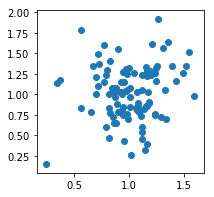

In [2]:
def build_2d_data(N, beta=0.1):
    """ 
    2d, Mulitvariate Guassian data
    """
    mu = [1, 1]
    Sigma = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N):
        x[n, :] = np.random.multivariate_normal(mu, Sigma)
        
    return x
X = build_2d_data(100)
plt.figure(figsize=(3,3))
plt.scatter(X[:,0], X[:, 1])

In [3]:
D = 2
X_train = X[0:-1]; y_train = X[1:]


In [166]:


class EdwardLinearDynamicSystem(object):
    
    def __init__(self, D, n_samples=100):
        """
        Parameters:
        -----------
        
        D: int
            dimensions of the data set
        
        n_samples: int
            number of samples to draw of the posterior
            
        """
        self.D = D
        self.x_train = np.zeros((0, self.D))  # initailize empty arrays
        self.y_train = np.zeros((0, self.D))
        
        
        # initialize samples, for untrained (new) models, predict X'_hat = X
        self.n_samples = n_samples
        self.w_samples = np.reshape(np.eye(D), (1, D, D))
        self.b_samples = np.zeros((1, D))
        
    def _initialize_model(self, N):
        """
        Parameters:
        -----------
        N: int
            training sample size
        """
        
        self.W_0 = Normal(loc=tf.zeros([self.D, self.D]), scale=tf.ones([self.D, self.D]), name="W_0")
        self.b_0 = Normal(loc=tf.zeros(self.D), scale=tf.ones(self.D), name="b_0")
        
        self.X = tf.placeholder(tf.float32, [N, self.D], name="X")
        
        self.y = MultivariateNormalDiag(
            loc=tf.matmul(self.X, self.W_0) + self.b_0, 
            scale_diag=0.1 * tf.ones(self.D), 
            name="y"
        )

        self.qW_0 = Normal(loc=tf.Variable(tf.random_normal([self.D, self.D]), name="loc"),
                           scale=tf.nn.softplus(tf.Variable(tf.random_normal([self.D, self.D]), name="scale")))        
        
        self.qb = Normal(loc=tf.Variable(tf.random_normal([self.D])),
                    scale=tf.nn.softplus(tf.Variable(tf.random_normal([self.D]))))
        
    def _train(self, x_train, y_train):
        """
        Parameters
        ----------
        
        x_train: NxD array
            N examplars of D-dimensional states
            
        y_train: NxD array
            N examplars of D-dimensional sucessor states
        
        """
        inference = ed.KLqp({self.W_0: self.qW_0, self.b_0: self.qb}, 
                            data={self.X: x_train, self.y: y_train})
        #inference.run(n_samples=5, n_iter=1000)
        inference.run(logdir='log')

    def update(self, X, Y, estimate=True):
        """
        Parameters
        ----------
        
        X: np.array, length D
            observed state vector
            
        Y: np.array, length D
            observed sucessor state vector
        """        
        self.x_train = np.concatenate([self.x_train, np.reshape(X, newshape=(1, 2))])
        self.y_train = np.concatenate([self.y_train, np.reshape(Y, newshape=(1, 2))])
        
        if estimate:
            # initialize and train the edward model
            N, D = self.x_train.shape
            self._initialize_model(N)
            self._train(self.x_train, self.y_train)
            
        # cache parameter samples for prediction

        # posterior predictive distribution
        y_post = ed.copy(self.y, {self.W_0: self.qW_0, self.b_0: self.qb})
        
        # try sampling from the posterior
        self.w_samples = self.W_0.sample(self.n_samples).eval()
        self.b_samples = self.b_0.sample(self.n_samples).eval()
            
        
    def log_likelihood(self, X, Y, Sigma):
        """
        Calculate a normal likelihood
        
        Parameters
        ----------
        X: np.array length D
            starting state vector
        
        Y: np.array length D
            sucessor state vector
            
        Sigma: DxD array
            covariance matrix for normal likelihood
            
        Returns
        -------
        
        ll: float
            log likelihood
        """
        
        
        Y_hat = self.predict(X)
        
        n = Y_hat.shape[0]  # number of samples
        LL = 0  # initialize log likelihood at zero
        
        for ii in range(n):
            LL += np.log(multivariate_normal.pdf(Y - Y_hat[ii, :], mean=np.zeros(self.D), cov=Sigma))
            
        return LL
        
                

                
    def predict(self, X):
        """
        Parameters
        ----------
        
        X: np.array, length D
            state vector
            
        Returns
        -------
        
        Y_hat: np.array, n_samples x D
            sample of predicted sucessors states
        """
        
        
        # reshape the scene vector
        n = self.w_samples.shape[0]  # number of samples stored
        X_test = np.tile(X, (n, 1))
        X_test = np.reshape(X_test, newshape=(n, 1, self.D))
        Y_hat = np.reshape(np.matmul(X_test, self.w_samples), newshape=(n, D)) + self.b_samples
    
        return np.reshape(Y_hat, newshape=(n, 1, D))


    
ed_model = EdwardLinearDynamicSystem(D)


In [167]:
class LinearDynamicSystem(object):

    def __init__(self, D, eta=0.01):
        """
        Parameters
        ----------
        D: int
            dimensions of the vector space of interest
            
        eta: float
            learning rate
        """
        
        self.beta = np.zeros(D).flatten()
        self.W = np.eye(D).flatten()
        self.eta = eta
        self.D = D
        
    def predict(self, X):
        """
        Parameters
        ----------
        X: np.array of length D
            vector at time t
        
        Returns
        -------
        Y_hat: np.array of length D
            prediction of vector at time t+1
        """
        Y_hat = self.beta + np.matmul(X, np.reshape(self.W , (self.D, self.D)))
        return Y_hat
    
    def log_likelihood(self, X, Y, Sigma):
        """
        Calculate a normal likelihood
        
        Parameters
        ----------
        X: np.array length D
            starting state vector
        
        Y: np.array length D
            sucessor state vector
            
        Sigma: DxD array
            covariance matrix for normal likelihood
            
        Returns
        -------
        
        ll: float
            log likelihood
        """
        
        Y_hat = self.predict(X)
        return multivariate_normal.pdf(Y - Y_hat, mean=np.zeros(self.D), cov=Sigma)
        
    def update(self, X, Y):
        """
        Parameters
        ----------
        
        X: np.array, length D
            observed state vector
            
        Y: np.array, length D
            observed sucessor state vector
        """
        Y_hat = self.predict(X)
        
        
        # needed for updating logic
        dXdb = np.eye(self.D)
        dXdW = np.tile((np.tile(X, (1, self.D))), (self.D, 1))
        g = np.concatenate([dXdb, dXdW], axis=1)
        
        # vectorize the parameters
        theta = np.concatenate([self.beta, self.W.flatten()])
        theta += self.eta * np.matmul(Y - Y_hat, g)
        
        # store the updated parameters
        self.beta = theta[:np.shape(X)[0]]
        self.W = theta[np.shape(X)[0]:]
        
        
    
class SEM(object):
    """
    This port of SAM's code (done with a different programming logic)
    in python. More documation to come!
    """
    
    def __init__(self, lmda=1., alfa=10.0, beta=0.1, f_class=None, f_opts=None):
        """
        Parameters
        ----------
        
        lmbda: float
            sCRP stickyness parameter
        
        alfa: float
            sCRP concentration parameter
        
        beta: float
            gaussian noise parameter
            
        f_class: class
            object class that has the functions "predict" and "update".
            used as the event model
            
        f_opts: dictionary
            kwargs for initializing f_class
        """
        self.lmda = lmda
        self.alfa = alfa
        self.beta = beta
        
        if f_class is None:
            self.f_class = LinearDynamicSystem
        else:
            self.f_class = f_class
        if f_opts is None:
            self.f_opts = {'eta': 0.01}
        else:
            self.f_opts = f_opts

            
    def run(self, X, K=None):
        """
        Parameters
        ----------
        X: N x D array of 
        
        K: int
            maximum number of clusters
        
        Return
        ------
        post: N by K array of posterior probabilites
        """
        
        [N, D] = np.shape(X)
        
        Sigma = np.eye(D) * self.beta  # noise for multivariate gaussian likelihood

        if K is None:
            K = N
        
        C = np.zeros(K)  # running count of the clustering process
        prior = C.copy()
        
        event_models = dict()  # initialize an empty event model space
        
        x_prev = np.zeros(D)  # need a starting location as is sequential model
        post = np.zeros((N, K))
        
        for n in range(N):
            # calculate sCRP prior
            prior = C.copy()
            idx =  len(np.nonzero(C)[0])  # get number of visited clusters
            
            if idx < K:
                prior[idx] = self.alfa  # set new cluster probability to alpha

            # add stickyness parameter for n>0
            if n > 0: 
                prior[np.argmax(post[n, :])] + self.lmda 

            prior /= np.sum(prior)
            
            # likelihood
            active = np.nonzero(prior)[0]
            lik = np.zeros(len(active))
            
            for k in active:
                if k not in event_models.keys():
                    event_models[k] = self.f_class(D, **self.f_opts)
                
                # get the log likelihood for each event model
                model = event_models[k]
                lik[k] = model.log_likelihood(x_prev, X[n, :], Sigma)
                
                
            # posterior
            p = np.log(prior[:len(active)]) + lik
            post[n, :len(active)] = np.exp(p - logsumexp(p))

            # update 
            k = np.argmax(post[n, :]) # MAP cluster
            C[k] += 1 # update counts
            event_models[k].update(x_prev, X[n, :])  # update event model
            
            x_prev = X[0, :].copy()  # store the current vector for next trial
        
        return post

Now, we define some toy problem

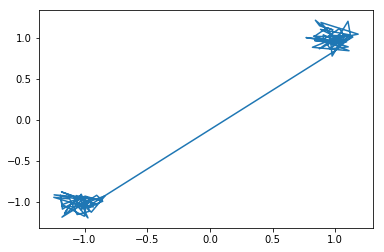

In [168]:
# first demo -- gaussian mixture defined by the CRP

def build_static_dataset(N, beta=0.1):
    """ 
    2 events, modeled as gaussians with different means
    """
    
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    stds = np.ones((2, 2)) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N/2):
        x[n, :] = np.random.multivariate_normal(mus[0], np.diag(stds[0]))
    for n in range(N/2, N):
        x[n, :] = np.random.multivariate_normal(mus[1], np.diag(stds[1]))
        
    return x

x_train = build_static_dataset(100, 0.01)
plt.plot(x_train[:, 0], x_train[:, 1])

In [169]:
K = 20  # maximum number of event types
lmda = 1  # stickyness parameter
alfa = 10.0  # concentration parameter
beta = 0.01 # transition noise
eta =  0.1  # learning rate

sem_kwargs = dict(lmda=lmda, alfa=alfa, beta=beta, 
                  f_class=LinearDynamicSystem, f_opts=dict(eta=eta))

sem = SEM(**sem_kwargs)
post = sem.run(x_train, K=K)

In [ ]:
def plot_segmentation(post):
    cluster_id = np.argmax(post, axis=1)
    import seaborn as sns
    cc = sns.color_palette('Dark2', post.shape[1])
    for clt in cluster_id:
        idx = np.nonzero(cluster_id == clt)[0]
        plt.scatter(x_train[idx, 0], x_train[idx, 1], color=cc[clt])
        
plot_segmentation(post)

In [162]:
K = 20  # maximum number of event types
lmda = 1  # stickyness parameter
alfa = 10.0  # concentration parameter
beta = 0.01 # transition noise
n_samples =  100  # learning rate

sem_kwargs = dict(lmda=lmda, alfa=alfa, beta=beta, 
                  f_class=EdwardLinearDynamicSystem, f_opts=dict(n_samples=n_samples))

sem2 = SEM(**sem_kwargs)
post = sem2.run(x_train, K=K)

[[ 0.97447973  1.01005268]]
1000/1000 [100%] ██████████████████████████████ Elapsed: 51s | Loss: 2.01416s | 
[[ 0.51654506  0.0089559 ]]
[[ 2.31964874 -0.46118236]]
[[ 0.09249008  0.94154739]]
[[ 0.91691601 -1.56048191]]
[[ 1.65985131  0.63482988]]
[[ 3.30836678  2.18158054]]
[[ 2.24679422  3.50939417]]
[[-1.46891868 -1.9980303 ]]
[[ 1.73389506  5.25835848]]
[[-0.58198488  2.30550528]]
[[ 0.3497411   1.22721732]]
[[-2.15078926  2.40633488]]
[[-1.74228585 -0.21175253]]
[[ 0.58806854  2.69222593]]
[[-1.59922636  4.76879787]]
[[-0.38127398 -2.71909857]]
[[ 0.86023378 -1.85055149]]
[[ 0.63379979 -2.33536673]]
[[-0.20542204  2.91986704]]
[[ 1.93136811  0.39139807]]
[[ 3.0027163  -1.18659508]]
[[ 0.33761466  0.8920635 ]]
[[ 0.1828326  -1.25385797]]
[[ 1.22231138 -1.77943552]]
[[ 2.06023002  2.00252628]]
[[ 0.9525314   2.39353943]]
[[ 3.5431242   2.63133955]]
[[ 0.00717568  0.14900613]]
[[-2.256598    0.15104109]]
[[ 1.63977432  0.38474822]]
[[ 0.81772947  0.99483168]]
[[ 2.63081932  1.165636

/Users/nickfranklin/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:128: RuntimeWarning: divide by zero encountered in log


KeyboardInterrupt: 

In [ ]:
plot_segmentation(post)

Now, alternative between two events


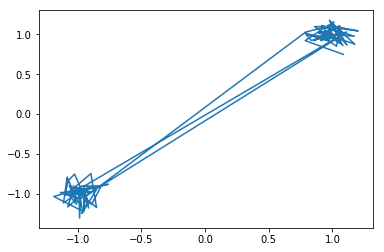

In [144]:
def build_alternating_static_events(N, beta=0.1):
    """ 
    2 alternating events, modeled as gaussians with different means
    """
    
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    stds = np.ones((2, 2)) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N/4):
        x[n, :] = np.random.multivariate_normal(mus[0], np.diag(stds[0]))
    for n in range(N/4, N/2):
        x[n, :] = np.random.multivariate_normal(mus[1], np.diag(stds[1]))
    for n in range(N/2, N/4*3):
        x[n, :] = np.random.multivariate_normal(mus[0], np.diag(stds[0]))
    for n in range(N/4*3, N):
        x[n, :] = np.random.multivariate_normal(mus[1], np.diag(stds[1]))
        
    return x

x_train = build_alternating_static_events(100, 0.01)
plt.plot(x_train[:, 0], x_train[:, 1])

In [145]:
post = sem.run(x_train, K=K)

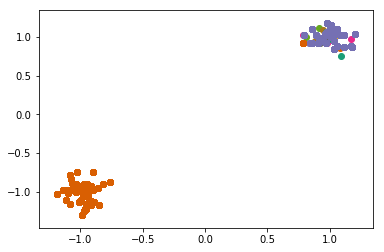

In [146]:
plot_segmentation(post)

In [147]:
#show the envent number that was chosen. Notice the re-use of events
np.argmax(post, axis=1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17,  2,  2, 18, 19,  2,  2,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

Below an example of two events where the events correspond to movement in vector space

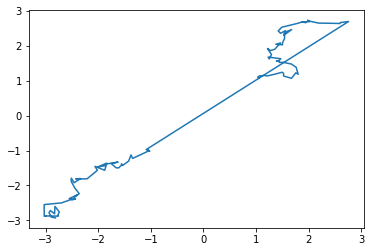

In [41]:

def build_moving_data(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    stds = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], stds)
    for n in range(1, N/2):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, stds)
        
    x[N/2, :] = np.random.multivariate_normal(bs[1], stds)
    for n in range(N/2+1, N):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, stds)
    return x

x_train = build_moving_data(100)
plt.plot(x_train[:, 0], x_train[:, 1])

In [42]:
post = sem.run(x_train, K=K)

/Users/nickfranklin/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:167: RuntimeWarning: divide by zero encountered in log


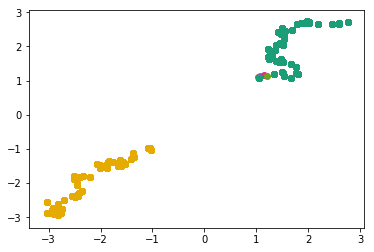

In [43]:
plot_segmentation(post)

In [44]:
np.argmax(post, axis=1)

array([0, 1, 2, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5])

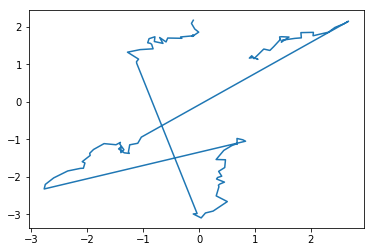

In [63]:

def build_alternating_moving_events(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1], [1, -1], [-1, 1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    Sigma = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], Sigma)
    for n in range(1, N/4):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4, :] = np.random.multivariate_normal(bs[1], Sigma)
    for n in range(N/4+1, N/2):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
            
    x[N/2, :] = np.random.multivariate_normal(bs[2], Sigma)
    for n in range(N/2+1, N/4*3):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4*3, :] = np.random.multivariate_normal(bs[3], Sigma)
    for n in range(N/4*3+1, N):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)      
        
    return x

x_train = build_alternating_moving_events(100)
plt.plot(x_train[:, 0], x_train[:, 1])

In [64]:
post = sem.run(x_train, K=K)

/Users/nickfranklin/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:167: RuntimeWarning: divide by zero encountered in log


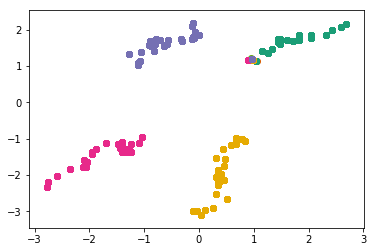

In [65]:
plot_segmentation(post)

In [66]:
np.argmax(post, axis=1)

array([0, 1, 2, 3, 4, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2])

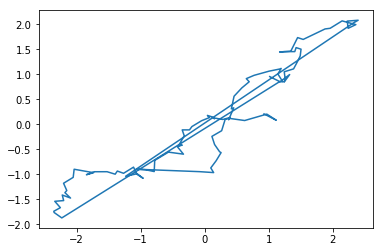

In [67]:

def build_alternating_moving_events(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1], [1, -1], [-1, 1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    Sigma = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], Sigma)
    for n in range(1, N/4):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4, :] = np.random.multivariate_normal(bs[1], Sigma)
    for n in range(N/4+1, N/2):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
            
    x[N/2, :] = np.random.multivariate_normal(bs[0], Sigma)
    for n in range(N/2+1, N/4*3):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4*3, :] = np.random.multivariate_normal(bs[1], Sigma)
    for n in range(N/4*3+1, N):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)      
        
    return x

x_train = build_alternating_moving_events(100)
plt.plot(x_train[:, 0], x_train[:, 1])

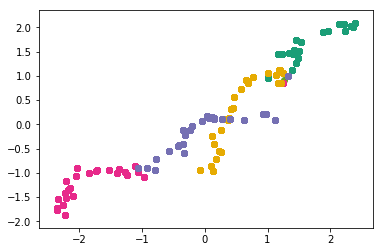

In [68]:
plot_segmentation(post)

In [70]:
(2560**2 + 1600**2)**.5 / 13.3

226.98300468106115